# Previsão de vazão de rios

Utilizam-se os dados de furnas e de camargos.

Importam-se as seguintes bibliotecas externas:

 - pandas
 - matplotlib
 - statsmodels
 - sklearn
 - seaborn
 - numpy
 - keras
 - theano
 
A aplicação jupyternotify é usada para notificar o fim da execução do código

In [1]:
%load_ext jupyternotify
%autonotify -a 10

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import pickle

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#import tensorflow as tf
#sess_cpu = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
os.environ['KERAS_BACKEND'] = 'theano'
#export THEANO_FLAGS=blas.ldflags="-L${MKLROOT}/lib/intel64 -lmkl_rt -lpthread -lm -ldl"
#os.environ['THEANO_FLAGS'] = blas.ldflags="-L/usr/lib64/atlas/ -lptf77blas -lptcblas -latlas"' #'blas.ldflags="-L/usr/lib64/ -lblas"'#'blas.ldflags="-L/usr/lib64/ -lf77blas -latlas -lgfortran"' #"-L/usr/local/lib/ -lblas"'

from keras.models import Sequential, load_model, Model
from keras import regularizers
from keras.layers import Concatenate, Permute, Dot, Input, LSTM, Multiply, RepeatVector, Dense, Activation, Lambda
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, GaussianNoise, GaussianDropout, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (15, 10)
if not os.path.exists('historicos'):
    os.makedirs('historicos')
if not os.path.exists('modelos'):
    os.makedirs('modelos')

Using Theano backend.


In [3]:
def imprime_metricas(real, predito, fator_normalizacao):
    #print('RMSE = ', np.sqrt(np.mean(np.square(predito - real)))*fator_normalizacao, end=', ')
    print('RMSE = ', metrics.mean_squared_error(real, predito)*fator_normalizacao , end=', ')
    #print('MAE = ', 100*np.mean(np.abs(predito-real)/real)*, '%', end=', ')
    print('MAE = ', metrics.mean_absolute_error(real, predito)*100, '%' , end=', ')
    print('R = ', metrics.r2_score(real, predito))

def mostra_treinamento(historico, init=16):
    plt.plot(historico['loss'][init:])
    plt.plot(historico['val_loss'][init:])
    plt.ylabel('Erro Quadrático Médio')
    plt.xlabel('Iterações')
    plt.legend(['Treinamento', 'Validação'], loc='upper right')
    plt.show()

def mostra_performance(modelo, entrada, saida, fatores_normalizacao):
    predito = modelo.predict(entrada)
    for i in range(len(fatores_normalizacao)):
        plt.plot(saida[:, i], '-o')
        plt.plot(predito[:, i], '-o')
        plt.legend(['Real', 'Predito'], loc='upper right')
        plt.xticks(np.arange(0, len(saida), step=12))
        plt.show()
        imprime_metricas(saida[:, i], predito[:, i], fatores_normalizacao[i])

def salva_historico(historico, nome_arquivo):
    arquivo = open(nome_arquivo, 'wb')
    pickle.dump(historico, arquivo)
    arquivo.close()

def carrega_historico(nome_arquivo):
    try:
        arquivo = open(nome_arquivo, 'rb')
        historico = pickle.load(arquivo)
        arquivo.close()
    except:
        return False
    return historico

Carregamento dos dados

In [4]:
janela = 24
adicional_reco = 48
teste = 120
fracao_valida = 0.2

Os dados são separados em um conjunto de treinamento, de validação e de teste.

In [5]:
def separa_serie(serie, janela, inicio_y, tam):
    y_separado = serie[inicio_y:inicio_y+tam].reshape((tam, 1))
    x_separado = np.zeros((tam, janela))
    for i in range(tam):
        x_separado[i] = serie[i+inicio_y-janela:i+inicio_y]
    return x_separado, y_separado

def separa_series(serie1, serie2, janela, inicio_y, tam):
    x_separado = np.zeros((tam, 2*janela))
    for i in range(tam):
        x_separado[i, 0:janela] = serie1[i+inicio_y-janela:i+inicio_y]
        x_separado[i, janela:2*janela] = serie2[i+inicio_y-janela:i+inicio_y]
    y_separado = np.zeros((tam, 2))
    y_separado[:, 0] = serie1[inicio_y:inicio_y+tam]
    y_separado[:, 1] = serie2[inicio_y:inicio_y+tam]
    return x_separado, y_separado

def gera_meses(inicio_y, tam):
    meses = np.zeros((tam, 12))
    for i in range(tam):
        meses[i, (i+inicio_y)%12] = 1
    return meses

def separa_series_reco(serie1, serie2, janela, inicio_y, tam):
    x_separado = np.zeros((tam, janela, 2))
    for i in range(tam):
        x_separado[i, :, 0] = serie1[i+inicio_y-janela:i+inicio_y]
        x_separado[i, :, 1] = serie2[i+inicio_y-janela:i+inicio_y]
    y_separado = np.zeros((tam, 2))
    y_separado[:, 0] = serie1[inicio_y:inicio_y+tam]
    y_separado[:, 1] = serie2[inicio_y:inicio_y+tam]
    return x_separado, y_separado

def gera_meses_reco(janela, inicio_y, tam):
    meses = np.zeros((tam, janela, 12))
    for i in range(tam):
        for j in range(janela):
            meses[i, j, (i+j+inicio_y)%12] = 1
    return meses

In [6]:
furnas = np.array([float(a) for a in open('dados/furnas.csv', 'r').read().split('\n') if a])
camargos = np.array([float(a) for a in open('dados/camargos.csv', 'r').read().split('\n') if a])
assert(len(furnas) == len(camargos))
fatores_normalizacao = [furnas.max(), camargos.max()]
furnas /= fatores_normalizacao[0]
camargos /= fatores_normalizacao[1]
valida = int((len(furnas) - teste - janela) * fracao_valida)
treino = len(furnas) - teste - valida - janela

x_treina, y_treina = separa_series(furnas, camargos, janela, janela, treino)
m_treina = gera_meses(janela, treino)
x_valida, y_valida = separa_series(furnas, camargos, janela, janela+treino, valida)
m_valida = gera_meses(janela+treino, valida)
x_teste, y_teste = separa_series(furnas, camargos, janela, janela+treino+valida, teste)
m_teste = gera_meses(janela+treino+valida, teste)

assert(x_treina[31, -1] == y_treina[30, -1])
print('Treino, ', treino)
print('Validação, ', valida)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela)

Treino,  672
Validação,  168
Teste,  120
Total,  960


In [7]:
np.corrcoef(furnas, camargos)

array([[1.       , 0.9530124],
       [0.9530124, 1.       ]])

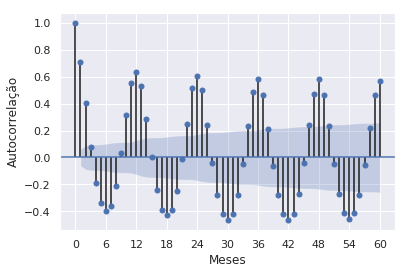

In [8]:
plot_acf(furnas, lags=60)
plt.xticks(np.arange(0, 61, step=6))
plt.title('')
plt.ylabel('Autocorrelação')
plt.xlabel('Meses')
plt.show()
plt.rcParams["figure.figsize"] = (14, 8)

## ARIMA

Análise inicial dos dados por decomposição aditiva

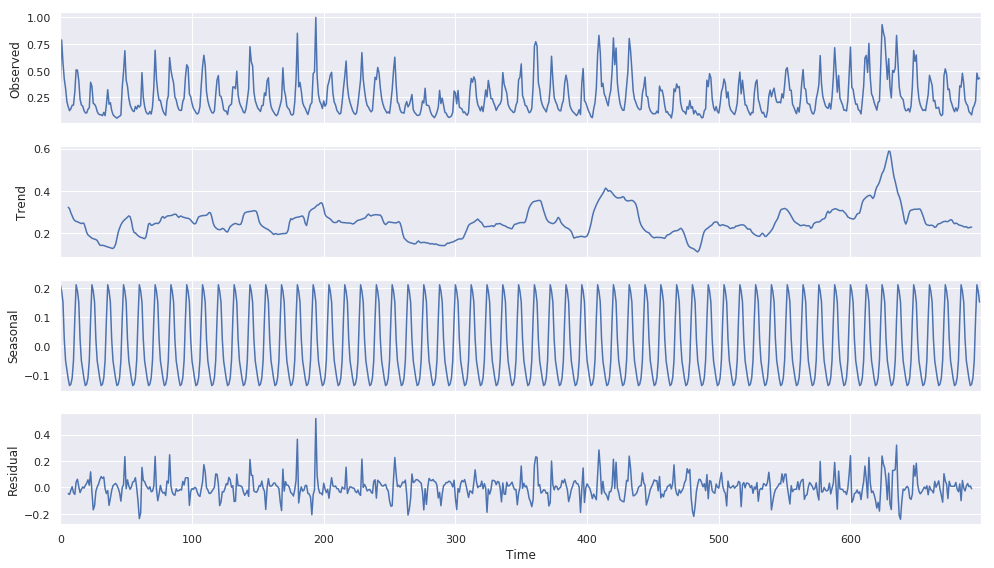

In [7]:
treino_arima = furnas[:len(x_treina)+janela]
decomposicao = seasonal_decompose(treino_arima, model='additive', freq=12)
decomposicao.plot()
plt.show()

Observação do modelo ARIMA no conjunto de treinamento

In [8]:
modelo_arima = auto_arima(treino_arima, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
                  d=0, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

print(modelo_arima.aic())
modelo_arima.fit(treino_arima)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-1165.280, BIC=-1142.531, Fit time=0.953 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-519.842, BIC=-510.743, Fit time=0.124 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-1206.436, BIC=-1188.237, Fit time=0.846 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-1048.820, BIC=-1030.622, Fit time=0.974 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1068.658, BIC=-1055.009, Fit time=0.123 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=-1251.626, BIC=-1228.877, Fit time=5.099 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1367.242, BIC=-1339.944, Fit time=5.684 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1048.671, BIC=-1025.922, Fit time=4.808 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1357.415, BIC=-1325.567, Fit time=7.871 seconds
Fit ARIMA: o

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

<IPython.core.display.Javascript object>

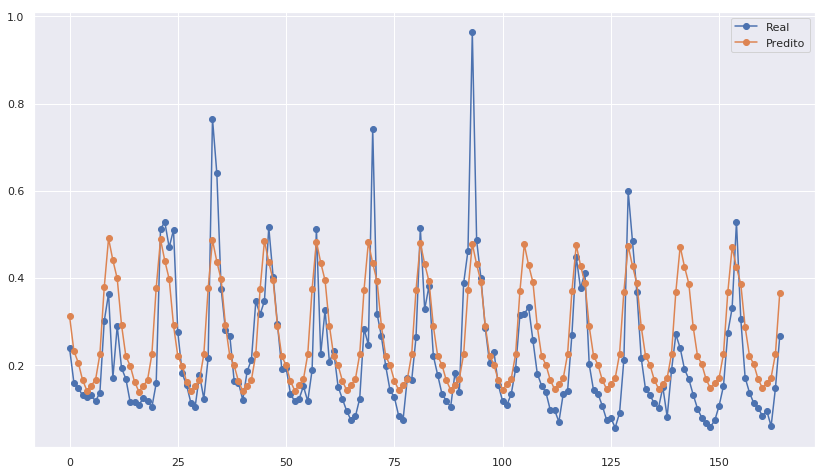

In [9]:
predito_arima = modelo_arima.predict(n_periods=valida)
plt.plot(furnas[len(treino_arima):len(treino_arima)+valida], '-o')
plt.plot(predito_arima, '-o')
plt.legend(['Real', 'Predito'], loc='upper right')
plt.show()

In [10]:
imprime_metricas(y_valida.ravel(), modelo_arima.predict(n_periods=valida))

RMSE =  40.06686358920697, MARE =  7.902108617390434 %, R =  0.5302101963658529


Treinamento completo do modelo ARIMA

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-1395.957, BIC=-1372.149, Fit time=2.199 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-668.918, BIC=-659.395, Fit time=0.167 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-1447.502, BIC=-1428.456, Fit time=1.345 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-1257.691, BIC=-1238.645, Fit time=1.066 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1300.377, BIC=-1286.093, Fit time=0.127 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=-1517.045, BIC=-1493.237, Fit time=5.464 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1661.076, BIC=-1632.506, Fit time=7.273 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1341.062, BIC=-1317.254, Fit time=6.001 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1673.890, BIC=-1640.559, Fit time=9.748 seconds
Fit ARIMA: o

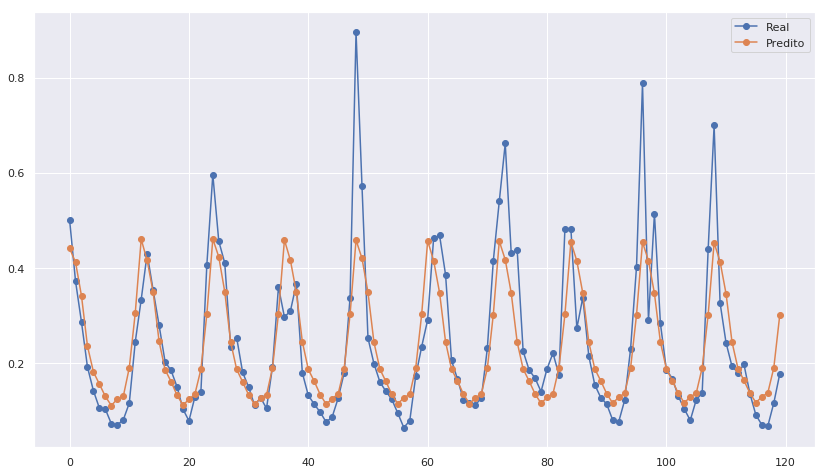

<IPython.core.display.Javascript object>

In [11]:
modelo_arima2 = auto_arima(furnas[:-teste], start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
                  d=0, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)
print(modelo_arima2.aic())
modelo_arima2.fit(furnas[:-teste])
plt.plot(furnas[-teste:], '-o')
plt.plot(modelo_arima2.predict(n_periods=teste), '-o')
plt.legend(['Real', 'Predito'], loc='upper right')
plt.show()

In [12]:
imprime_metricas(y_teste.ravel(), modelo_arima2.predict(n_periods=teste))

RMSE =  30.119591074696455, MARE =  6.025186131235192 %, R =  0.6976388302330081


# Um único neurônio (regressão linear)

Epoch 00237: early stopping


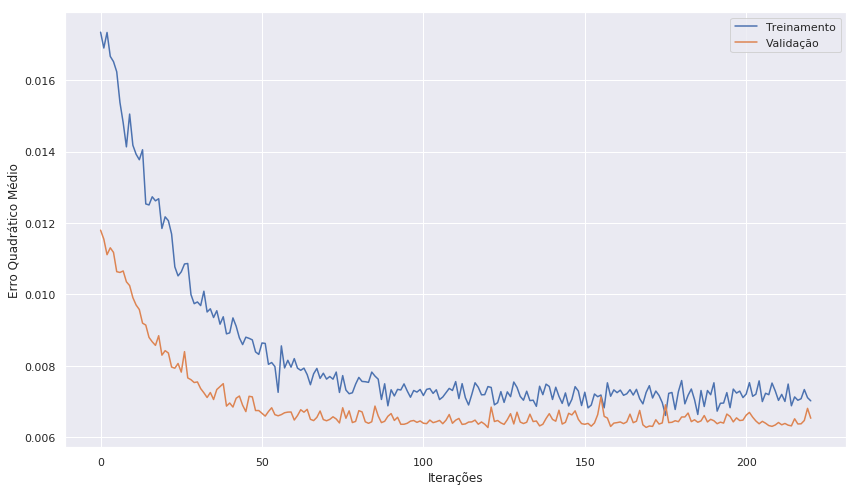

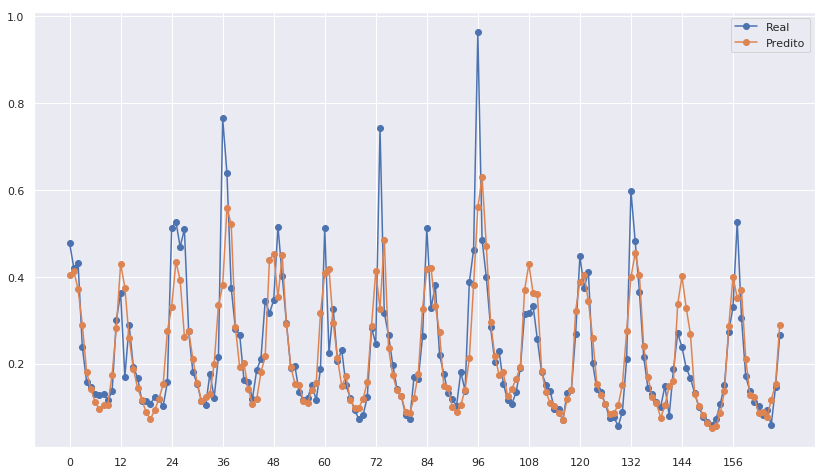

RMSE =  28.423457045415063, MAE =  5.3236381362669 %, R =  0.6733474031748763


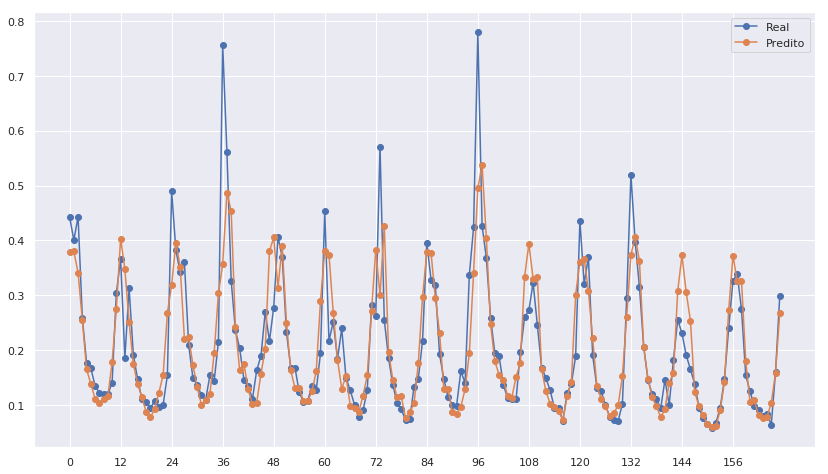

RMSE =  2.8643535148448045, MAE =  4.238486481662938 %, R =  0.6946639264588621


In [12]:
def modelo_uno(janela, quant_rios, ruido=0.05):
    entrada = Input(shape=(janela * quant_rios,))
    mes = Input(shape=(12,), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    estimativa = Dense(quant_rios, activation='relu')(entrada_aumentada)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_uno.h5'):# or True:
    uno = modelo_uno(janela, 2)
    uno.compile(optimizer='adam', loss='mse')
    parar_uno = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0)
    salvar_uno = ModelCheckpoint('modelos/melhor_uno.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_uno = uno.fit([x_treina, m_treina], y_treina, epochs=1000, validation_data=([x_valida, m_valida], y_valida), verbose=0, callbacks=[parar_uno, salvar_uno])
    salva_historico(historico_uno.history, 'historicos/uno')
    
mostra_treinamento(carrega_historico('historicos/uno'))
uno = load_model('modelos/melhor_uno.h5')
mostra_performance(uno, [x_valida, m_valida], y_valida, fatores_normalizacao)

# Multilayer perceptron

Epoch 00242: early stopping


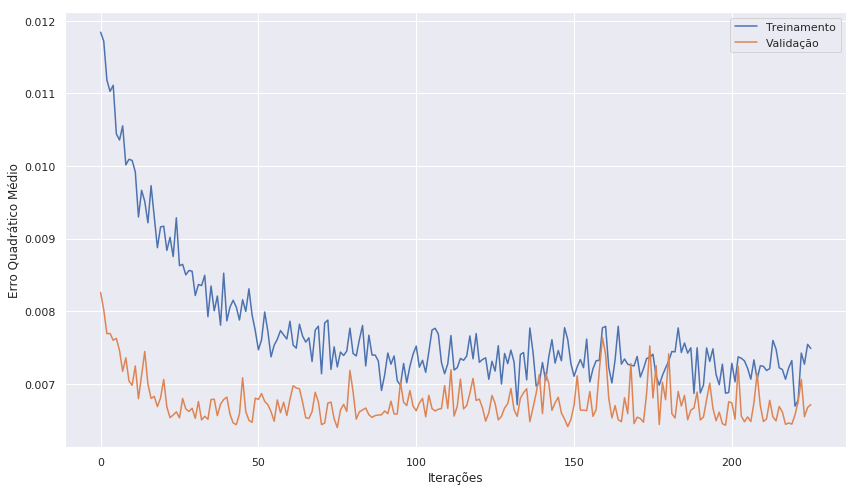

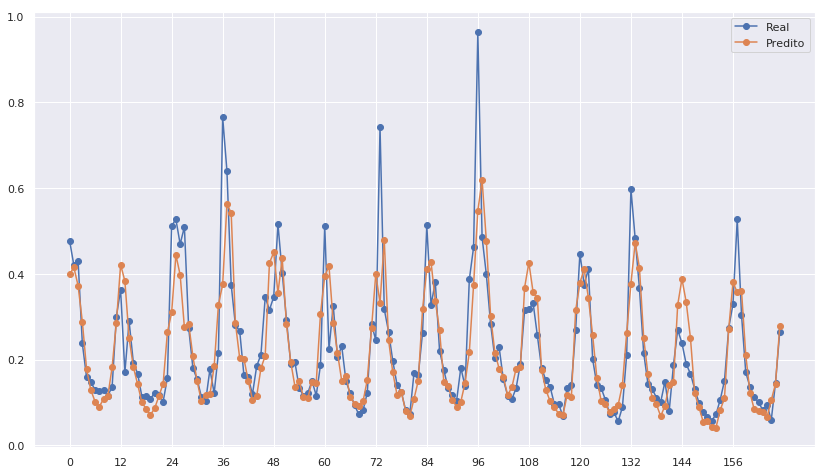

RMSE =  28.414394357907565, MAE =  5.3808181690085926 %, R =  0.6734515548410093


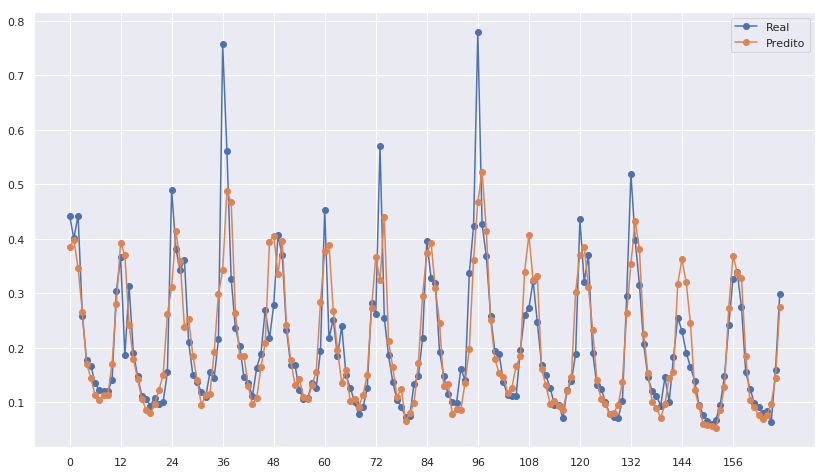

RMSE =  3.0159831835144755, MAE =  4.429357725555303 %, R =  0.6785004161156043


<IPython.core.display.Javascript object>

In [22]:
def modelo_mlp(janela, quant_rios, ruido=0.05): #sqrt(rate / (1 - rate))
    entrada = Input(shape=(janela*quant_rios,))
    mes = Input(shape=(12,), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    #X = Dense(8, activation='relu', kernel_regularizer=regularizers.l1(0.0001))(entrada_aumentada)
    X = Dense(12, activation='tanh')(entrada_aumentada)
    X = GaussianDropout(0.003)(X)
    X = Dense(6, activation='tanh')(X)
    X = GaussianDropout(0.001)(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_mlp.h5'):# or True:
    mlp = modelo_mlp(janela, 2)
    mlp.compile(optimizer='adam', loss='mse')
    parar_mlp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, min_delta=0)
    salvar_mlp = ModelCheckpoint('modelos/melhor_mlp.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_mlp = mlp.fit([x_treina, m_treina], y_treina, epochs=1000, validation_data=([x_valida, m_valida], y_valida), verbose=0, callbacks=[parar_mlp, salvar_mlp])
    salva_historico(historico_mlp.history, 'historicos/mlp')

mostra_treinamento(carrega_historico('historicos/mlp'))
mlp = load_model('modelos/melhor_mlp.h5')
mostra_performance(mlp, [x_valida, m_valida], y_valida, fatores_normalizacao)

## Divisão do conjuntos de dados para redes recorrentes

Para o treinamento de redes recorrentes no Keras é necessário escrever um tensor de ordem 3

In [23]:
janela_reco = janela + adicional_reco
valida_reco = int((len(furnas) - teste - janela_reco) * fracao_valida)
treino_reco = len(furnas) - teste - valida_reco - janela_reco

x_treina_reco, y_treina_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco, treino_reco)
m_treina_reco = gera_meses_reco(janela_reco, janela_reco, treino_reco)
x_valida_reco, y_valida_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco+treino_reco, valida_reco)
m_valida_reco = gera_meses_reco(janela_reco, janela_reco+treino_reco, valida_reco)
x_teste_reco, y_teste_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco+treino_reco+valida_reco, teste)
m_teste_reco = gera_meses_reco(janela_reco, janela_reco+treino_reco+valida_reco, teste)

assert(x_treina_reco[31, -1, -1] == y_treina_reco[30, -1])
print('Treino, ', treino_reco)
print('Validação, ', valida_reco)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela_reco)

Treino,  634
Validação,  158
Teste,  120
Total,  912


## Rede Recorrente Simples

Epoch 00372: early stopping


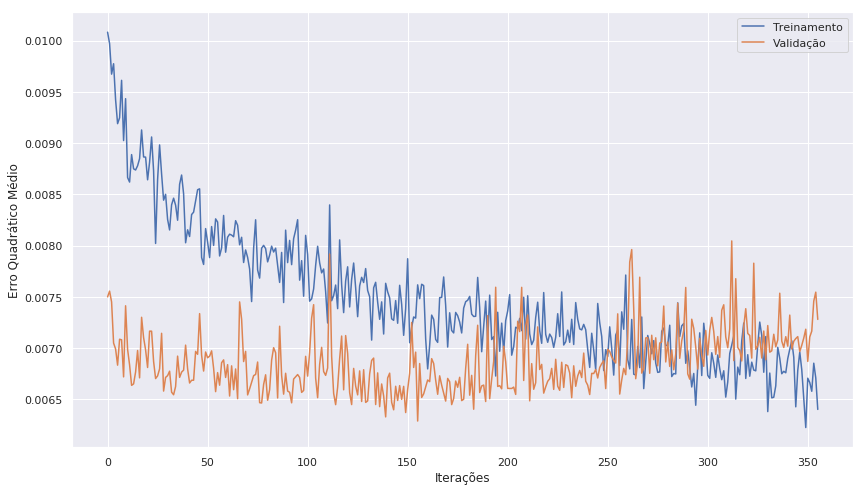

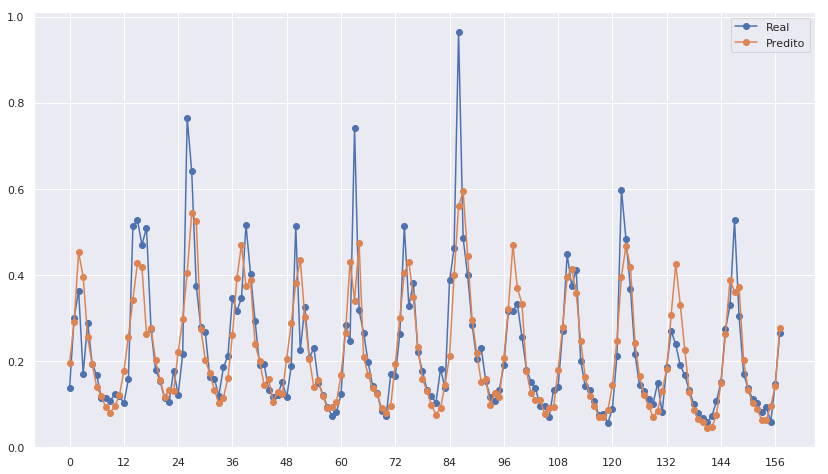

RMSE =  28.932089368803712, MAE =  5.385555022362198 %, R =  0.6708316898531013


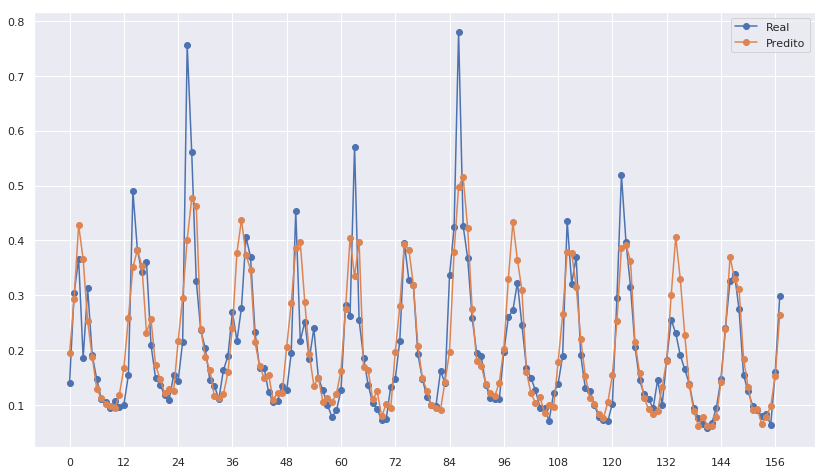

RMSE =  2.8092628738283008, MAE =  4.280716059244803 %, R =  0.6980629254220128


<IPython.core.display.Javascript object>

In [33]:
def modelo_reco(janela, quant_rios, ruido=0.04): #sqrt(rate / (1 - rate))
    entrada = Input(shape=(janela, quant_rios))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    #X = Dense(6, activation='relu', kernel_regularizer=regularizers.l1(0.0001))(entrada_aumentada)
    #X = GaussianDropout(0.004)(X)
    X = SimpleRNN(12)(entrada_aumentada)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='elu')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_reco.h5'):# or True:
    reco = modelo_reco(janela_reco, 2)
    reco.compile(optimizer='adam', loss='mse')
    parar_reco = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, min_delta=0)
    salvar_reco = ModelCheckpoint('modelos/melhor_reco.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_reco = reco.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=1000, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_reco, salvar_reco])
    salva_historico(historico_reco.history, 'historicos/reco')

mostra_treinamento(carrega_historico('historicos/reco'))
reco = load_model('modelos/melhor_reco.h5')
mostra_performance(reco, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

# LSTM

Epoch 00613: early stopping


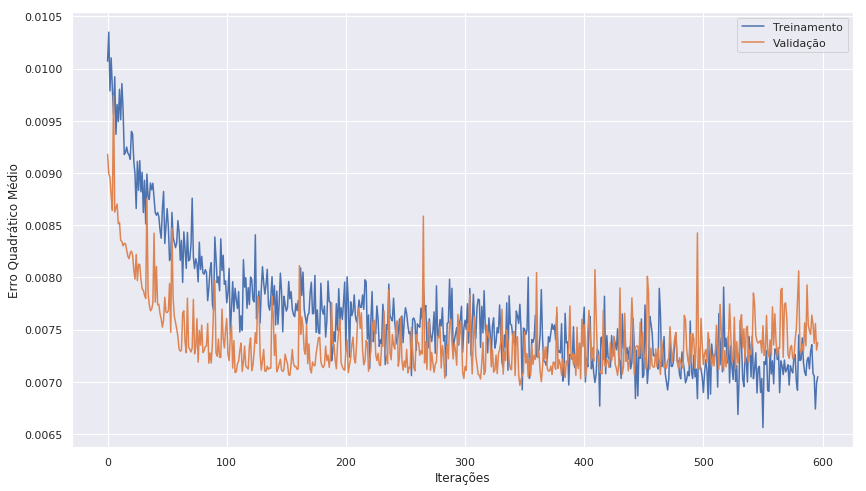

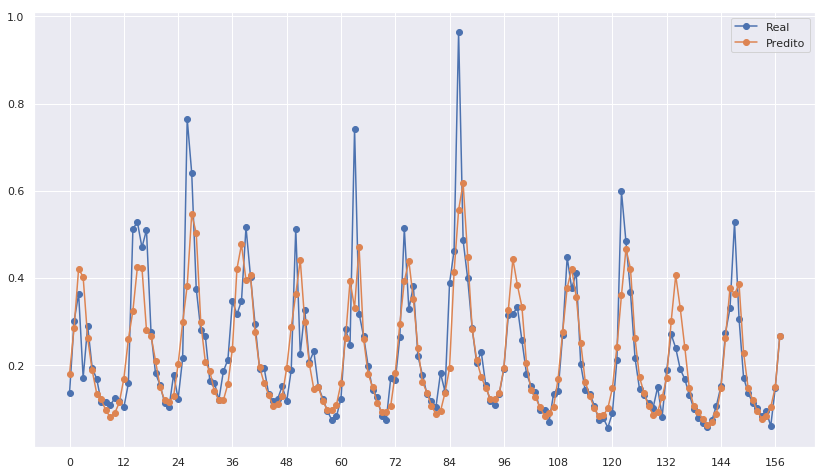

RMSE =  29.29509236255146, MAE =  5.204951612670692 %, R =  0.6667017053052499


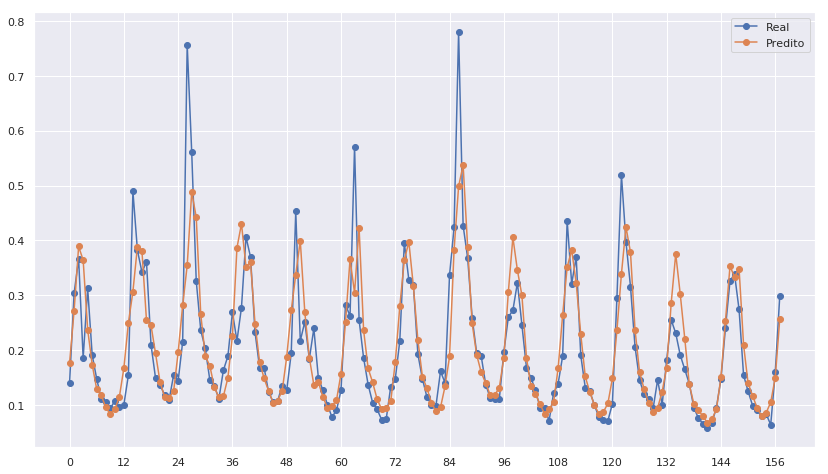

RMSE =  2.999203257873284, MAE =  4.340288262033597 %, R =  0.6776483019145272


<IPython.core.display.Javascript object>

In [39]:
def modelo_lstm(janela, quant_rios, ruido=0.04): #sqrt(rate / (1 - rate))
    entrada = Input(shape=(janela, quant_rios))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(12, activation='relu', kernel_regularizer=regularizers.l1(0.0001))(entrada_aumentada)
    X = GaussianDropout(0.004)(X)
    X = LSTM(6)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='relu')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_lstm.h5') or True:
    lstm = modelo_lstm(janela_reco, 2)
    lstm.compile(optimizer='adam', loss='mse')
    parar_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=250, min_delta=0)
    salvar_lstm = ModelCheckpoint('modelos/melhor_lstm.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_lstm = lstm.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=1500, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_lstm, salvar_lstm])
    salva_historico(historico_lstm.history, 'historicos/lstm')

mostra_treinamento(carrega_historico('historicos/lstm'))
lstm = load_model('modelos/melhor_lstm.h5')
mostra_performance(lstm, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

## GRU

Epoch 00167: early stopping


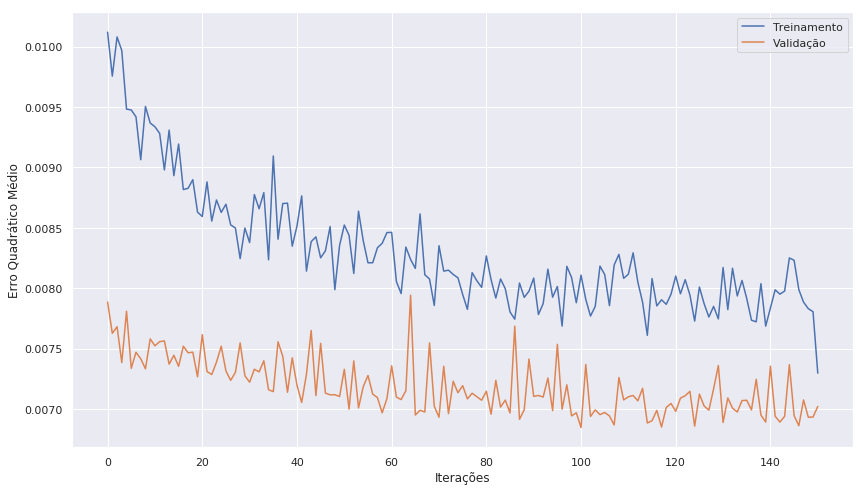

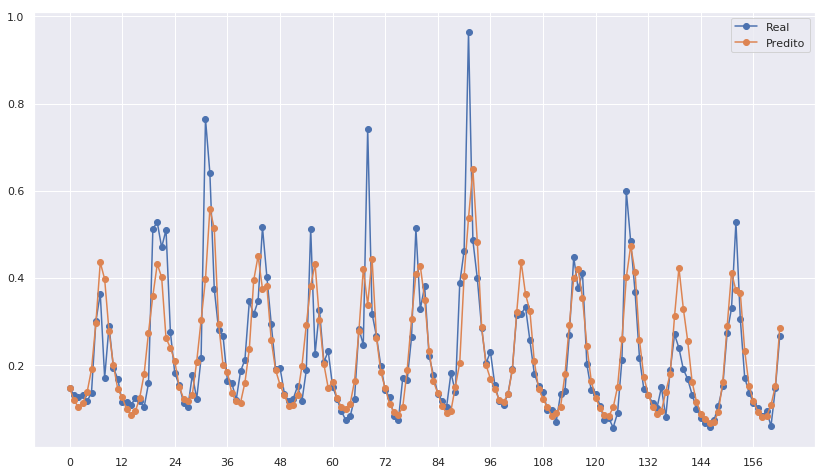

RMSE =  28.153859667441576, MAE =  5.162068697110991 %, R =  0.6735171809030103


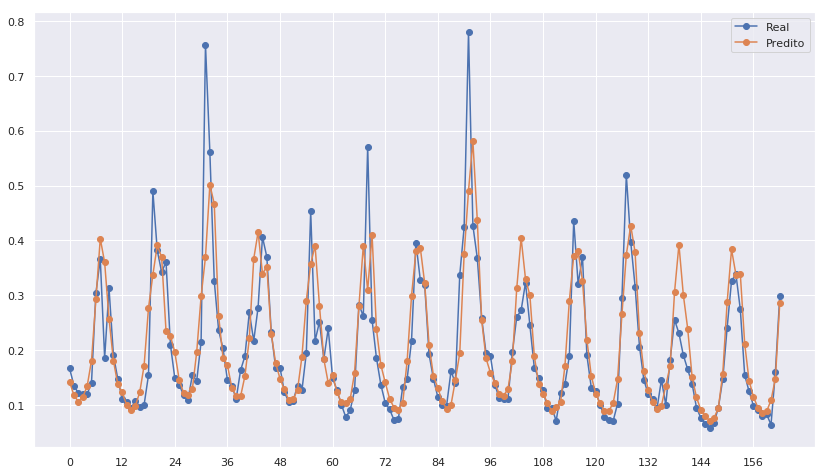

RMSE =  2.8901702096652078, MAE =  4.299456664775615 %, R =  0.6826699965611123


<IPython.core.display.Javascript object>

In [18]:
def modelo_gru(janela, quant_rios, ruido=0.04): #sqrt(rate / (1 - rate))
    entrada = Input(shape=(janela, quant_rios))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(6, activation='relu', kernel_regularizer=regularizers.l1(0.0001))(entrada_aumentada)
    X = GaussianDropout(0.004)(X)
    X = GRU(6)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='relu')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_gru2.h5') or True:
    gru = modelo_gru(janela_reco, 2)
    gru.compile(optimizer='adam', loss='mse')
    parar_gru = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, min_delta=0)
    salvar_gru = ModelCheckpoint('modelos/melhor_gru2.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_gru = gru.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=2000, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_gru, salvar_gru])
    salva_historico(historico_gru.history, 'historicos/gru2')

mostra_treinamento(carrega_historico('historicos/gru2'))
gru = load_model('modelos/melhor_gru2.h5')
mostra_performance(gru, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

## Teste dos modelos

In [19]:
executar_testes = False

if executar_testes:
    mostra_performance(uno, [x_teste, m_teste], y_teste, fatores_normalizacao)
    mostra_performance(mlp, [x_teste, m_teste], y_teste, fatores_normalizacao)
    mostra_performance(reco, [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao)
    mostra_performance(lstm, [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao)
    mostra_performance(gru , [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao)